# Imports

In [0]:
import numpy as np
import torch
torch.manual_seed(10)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import transforms, datasets
import pickle
import time
from google.colab import drive
from torchsummary import summary
drive.mount('/content/drive')
from torch.optim.lr_scheduler import StepLR
!pip install torch_optimizer
import torch_optimizer as optim
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import dill as dill

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Mean - std calculation

In [0]:
data_transform = transforms.Compose([
    transforms.RandomResizedCrop(128),
    #transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

Train_neu_dataset = datasets.ImageFolder(root='./drive/My Drive/Papsmear_dataset/smear2005Format/train',transform=data_transform)
Train_dataset_loader = torch.utils.data.DataLoader(Train_neu_dataset,batch_size=20,num_workers=4,shuffle=False)#shuffle=True for training add


mean = 0.
meansq = 0.
for data,labels in Train_dataset_loader:
    mean = data.mean()
    meansq = (data**2).mean()

std = torch.sqrt(meansq - mean**2)
print("mean: " + str(mean))
print("std: " + str(std))
print()

mean: tensor(0.6191)
std: tensor(0.1090)



In [0]:
mean = 0.0
meansq = 0.0
count = 0

for index, data_set in enumerate(Train_dataset_loader):
    data,labels = data_set
    mean = data.sum()
    meansq = meansq + (data**2).sum()
    count += np.prod(data.shape)

total_mean = mean/count
total_var = (meansq/count) - (total_mean**2)
total_std = torch.sqrt(total_var)
print("mean: " + str(total_mean))
print("std: " + str(total_std))

mean: tensor(0.0046)
std: tensor(0.5687)


In [0]:
mean = 0.0
for images, _ in Train_dataset_loader:
    batch_samples = images.size(0) 
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
mean = mean / len(Train_dataset_loader.dataset)
print('mean for the dataset',mean)
var = 0.0
for images, _ in Train_dataset_loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    var += ((images - mean.unsqueeze(1))**2).sum([0,2])
std = torch.sqrt(var / (len(Train_dataset_loader.dataset)*128*128))
print('standard deviation for the dataset',std)

mean for the dataset tensor([0.5241, 0.4949, 0.5741])
standard deviation for the dataset tensor([0.1864, 0.2078, 0.2274])


## Training loop

In [0]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)



def visualize(Train_dataset_loader,classes):
  import matplotlib.pyplot as plt
  import numpy as np
  # functions to show an image
  def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
  # get some random training images
  dataiter = iter(Train_dataset_loader)
  images, labels = dataiter.next()
  # show images
  imshow(torchvision.utils.make_grid(images))
  print(' '.join('%5s' % classes[labels[j]] for j in range(5)))


def createLossAndOptimizer(net, learning_rate=0.001):
    #Loss function
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    #optimizer = optim.RAdam(net.parameters(), lr=learning_rate)# with RAdam
    return(loss, optimizer)

def trainNet(net, batch_size, n_epochs, learning_rate):

    data_transform_train = transforms.Compose([
        transforms.Resize([224,224], interpolation=2),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomAffine(3, translate=(0.1,0.9), scale= None, shear=None,resample=False, fillcolor=0),
        transforms.ColorJitter(brightness=0.6, contrast=0.6, saturation=0.02, hue=0.01),
        transforms.RandomPerspective(distortion_scale=0.01, p=0.5, interpolation=3, fill=0),
        #transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize([0.5370, 0.4916, 0.5907], [0.1948, 0.2018, 0.2265]),
        AddGaussianNoise(0.1, 0.2)
    ])
    Train_neu_dataset = datasets.ImageFolder(root='./drive/My Drive/Papsmear_dataset/smear2005Format/train',transform=data_transform_train)
    Train_dataset_loader = torch.utils.data.DataLoader(Train_neu_dataset,batch_size=batch_size,num_workers=4,shuffle=True)#shuffle=True for training add

    data_transform_valid = transforms.Compose([
        transforms.Resize([224,224], interpolation=2),
        transforms.ToTensor(),
        transforms.Normalize([0.5370, 0.4916, 0.5907], [0.1948, 0.2018, 0.2265])
    ])


    valid_neu_dataset = datasets.ImageFolder(root='./drive/My Drive/Papsmear_dataset/smear2005Format/val',transform=data_transform_valid)
    valid_dataset_loader = torch.utils.data.DataLoader(valid_neu_dataset,batch_size=5, shuffle=True,num_workers=4)


    classes = ('im_Dyskeratotic','im_Koilocytotic','im_Metaplastic','im_Parabasal','im_Superficial-Intermediate')

    visualize(Train_dataset_loader,classes)
    
    #Print all of the hyperparameters of the training iteration:
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)
    
    n_batches = len(Train_dataset_loader)
    
    #Create our loss and optimizer functions
    loss, optimizer = createLossAndOptimizer(net, learning_rate)

    scheduler = StepLR(optimizer, step_size=50, gamma=0.1)
   
    #Time for printing
    training_start_time = time.time()
    train_losses, valid_losses = [], []
    #Loop for n_epochs
    for epoch in range(n_epochs):
        running_loss = 0.0
        print_every = n_batches // 10
        start_time = time.time()
        total_train_loss = 0
        accuracy = 0
        total = 0
        for i, data in enumerate(Train_dataset_loader, 0):
            inputs, labels = data
            inputs, labels = Variable(inputs), Variable(labels)
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss_size = loss(outputs, labels)
            loss_size.backward()
            optimizer.step()
            running_loss += loss_size.item()
            total_train_loss += loss_size.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
            
            #Print every 10th batch of an epoch
            if (i + 1) % (print_every + 1) == 0:
                
                print("Epoch {}, Batch_no {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
                        epoch+1, i ,int(100 * (i+1) / n_batches), running_loss / print_every, time.time() - start_time))
                running_loss = 0
                start_time = time.time()
        print('Training accuracy: %d %%' % (100 * accuracy / total))
        scheduler.step()    
        #At the end of the epoch, do a pass on the test set
        total_test_loss = 0
        valid_accuracy = 0
        total = 0
        net = net.eval()
        for inputs, labels in valid_dataset_loader:
            inputs, labels = Variable(inputs), Variable(labels)
            inputs, labels = inputs.to(device), labels.to(device)
            test_outputs = net(inputs)
            test_loss_size = loss(test_outputs, labels)
            total_test_loss += test_loss_size.item()
            _, predicted = torch.max(test_outputs.data, 1)
            total += labels.size(0)
            valid_accuracy += (predicted == labels).sum().item()
        train_losses.append(total_train_loss/len(Train_dataset_loader))
        valid_losses.append(total_test_loss/len(valid_dataset_loader))
        print('Validation accuracy: %d %%' % (100 * valid_accuracy / total))
        print("Validation loss = {:.2f}".format(total_test_loss / len(valid_dataset_loader)))
        net = net.train()
    data_transform = transforms.Compose([
        transforms.Resize([224,224], interpolation=2),
        #transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize([0.5370, 0.4916, 0.5907], [0.1948, 0.2018, 0.2265])
    ])
    Test_neu_dataset = datasets.ImageFolder(root='./drive/My Drive/Papsmear_dataset/smear2005Format/test',transform=data_transform)
    Test_dataset_loader = torch.utils.data.DataLoader(Test_neu_dataset,batch_size=10, shuffle=True,num_workers=4)

    confusion_matrix = torch.zeros(5, 5) # no_classes*no_classes

    def test_label_predictions(net, device, Test_dataset_loader):
      net.eval()
      net = net.to("cpu")
      # @victor: torch.save and save mehtod to pth file
      torch.save(net.state_dict(), './drive/My Drive/Papsmear_dataset/testnet_normalized.pth')
      
      net = net.to(device, )
      correct = 0
      total = 0
      for data, classes in Test_dataset_loader:
          data, classes = data.to(device), classes.to(device)
          output = net(data)
          _, preds = torch.max(output, 1)
          total += classes.size(0)
          correct += (preds == classes).sum().item()
          for t, p in zip(classes.view(-1), preds.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1
      print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))
      return confusion_matrix,correct,total
    # net = net.eval()
    confusion_matrix,correct, total = test_label_predictions(net, device, Test_dataset_loader)
    print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))
    print('Confusion matrix:')
    print(confusion_matrix)
    
    print("Training finished, took {:.2f}s".format(time.time() - training_start_time))
    return train_losses,valid_losses

In [0]:
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()
    
    def forward(self, x):
        # Do your print / debug stuff here
        print(x.shape)
        return x

class simple_testnet(nn.Module):
  def __init__(self, num_classes):
    self.num_classes = num_classes
    super(simple_testnet, self).__init__()

    self.cnn_layers = nn.Sequential(
            # Defining a 2D convolution layer: conv1
            nn.Conv2d(3, 4, kernel_size=3, stride=1, padding=1), #starting size:224*224*3
            nn.BatchNorm2d(4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer: conv2
            nn.Conv2d(4, 4, kernel_size=3, stride=1, padding=1), #after conv1, size:112*112*4
            nn.BatchNorm2d(4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer: conv3
            nn.Conv2d(4, 4, kernel_size=3, stride=1, padding=1), #after conv2, size:56*56*4
            nn.BatchNorm2d(4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer: conv4
            nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=1), #after conv3, size:28*28*4
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer: conv5
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1), #after conv4, size:14*14*8
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #output after conv5, size:7*7*16
        )
    
    self.linear_layers = nn.Sequential(
            nn.Linear(in_features=16 * 7 * 7, out_features=8*7*7),
            nn.ReLU(inplace=True),
            nn.Linear(8 * 7 * 7, self.num_classes)
        )
    
    # Defining the forward pass    
  def forward(self, x):
      x = self.cnn_layers(x)
      x = x.view(x.size(0), -1)
      x = self.linear_layers(x)
      return x

In [0]:
"""
Creates a MobileNetV3 Model as defined in:
Andrew Howard, Mark Sandler, Grace Chu, Liang-Chieh Chen, Bo Chen, Mingxing Tan, Weijun Wang, Yukun Zhu, Ruoming Pang, Vijay Vasudevan, Quoc V. Le, Hartwig Adam. (2019).
Searching for MobileNetV3
arXiv preprint arXiv:1905.02244.
"""

import torch.nn as nn
import math


__all__ = ['mobilenetv3_large', 'mobilenetv3_small']


def _make_divisible(v, divisor, min_value=None):
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    :param v:
    :param divisor:
    :param min_value:
    :return:
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


class h_sigmoid(nn.Module):
    def __init__(self, inplace=True):
        super(h_sigmoid, self).__init__()
        self.relu = nn.ReLU6(inplace=inplace)

    def forward(self, x):
        return self.relu(x + 3) / 6


class h_swish(nn.Module):
    def __init__(self, inplace=True):
        super(h_swish, self).__init__()
        self.sigmoid = h_sigmoid(inplace=inplace)

    def forward(self, x):
        return x * self.sigmoid(x)


class SELayer(nn.Module):
    def __init__(self, channel, reduction=4):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
                nn.Linear(channel, _make_divisible(channel // reduction, 8)),
                nn.ReLU(inplace=True),
                nn.Linear(_make_divisible(channel // reduction, 8), channel),
                h_sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


def conv_3x3_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        h_swish()
    )


def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        h_swish()
    )


class InvertedResidual(nn.Module):
    def __init__(self, inp, hidden_dim, oup, kernel_size, stride, use_se, use_hs):
        super(InvertedResidual, self).__init__()
        assert stride in [1, 2]

        self.identity = stride == 1 and inp == oup

        if inp == hidden_dim:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, kernel_size, stride, (kernel_size - 1) // 2, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                h_swish() if use_hs else nn.ReLU(inplace=True),
                # Squeeze-and-Excite
                SELayer(hidden_dim) if use_se else nn.Identity(),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                h_swish() if use_hs else nn.ReLU(inplace=True),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, kernel_size, stride, (kernel_size - 1) // 2, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                # Squeeze-and-Excite
                SELayer(hidden_dim) if use_se else nn.Identity(),
                h_swish() if use_hs else nn.ReLU(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        if self.identity:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileNetV3(nn.Module):
    def __init__(self, cfgs, mode, num_classes=5, width_mult=1.):
        super(MobileNetV3, self).__init__()
        # setting of inverted residual blocks
        self.cfgs = cfgs
        assert mode in ['large', 'small']

        # building first layer
        input_channel = _make_divisible(16 * width_mult, 8)
        layers = [conv_3x3_bn(3, input_channel, 2)]
        # building inverted residual blocks
        block = InvertedResidual
        for k, t, c, use_se, use_hs, s in self.cfgs:
            output_channel = _make_divisible(c * width_mult, 8)
            exp_size = _make_divisible(input_channel * t, 8)
            layers.append(block(input_channel, exp_size, output_channel, k, s, use_se, use_hs))
            input_channel = output_channel
        self.features = nn.Sequential(*layers)
        # building last several layers
        self.conv = conv_1x1_bn(input_channel, exp_size)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        output_channel = {'large': 1280, 'small': 1024}
        output_channel = _make_divisible(output_channel[mode] * width_mult, 8) if width_mult > 1.0 else output_channel[mode]
        self.classifier = nn.Sequential(
            nn.Linear(exp_size, output_channel),
            h_swish(),
            nn.Dropout(0.2),
            nn.Linear(output_channel, num_classes),
        )

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.conv(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                n = m.weight.size(1)
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()


    def mobilenetv3_large(**kwargs):
        """
        Constructs a MobileNetV3-Large model
        """
        cfgs = [
            # k, t, c, SE, HS, s 
            [3,   1,  16, 0, 0, 1],
            [3,   4,  24, 0, 0, 2],
            [3,   3,  24, 0, 0, 1],
            [5,   3,  40, 1, 0, 2],
            [5,   3,  40, 1, 0, 1],
            [5,   3,  40, 1, 0, 1],
            [3,   6,  80, 0, 1, 2],
            [3, 2.5,  80, 0, 1, 1],
            [3, 2.3,  80, 0, 1, 1],
            [3, 2.3,  80, 0, 1, 1],
            [3,   6, 112, 1, 1, 1],
            [3,   6, 112, 1, 1, 1],
            [5,   6, 160, 1, 1, 2],
            [5,   6, 160, 1, 1, 1],
            [5,   6, 160, 1, 1, 1]
        ]
        return MobileNetV3(cfgs, mode='large', **kwargs)


    def mobilenetv3_small(**kwargs):
        """
        Constructs a MobileNetV3-Small model
        """
        cfgs = [
            # k, t, c, SE, HS, s 
            [3,    1,  16, 1, 0, 2],
            [3,  4.5,  24, 0, 0, 2],
            [3, 3.67,  24, 0, 0, 1],
            [5,    4,  40, 1, 1, 2],
            [5,    6,  40, 1, 1, 1],
            [5,    6,  40, 1, 1, 1],
            [5,    3,  48, 1, 1, 1],
            [5,    3,  48, 1, 1, 1],
            [5,    6,  96, 1, 1, 2],
            [5,    6,  96, 1, 1, 1],
            [5,    6,  96, 1, 1, 1],
        ]

        return MobileNetV3(cfgs, mode='small', **kwargs)

Training cell

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


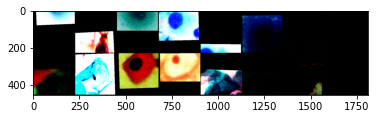

im_Parabasal im_Koilocytotic im_Parabasal im_Parabasal im_Parabasal
===== HYPERPARAMETERS =====
batch_size= 16
epochs= 210
learning_rate= 0.0009862520003992715
Epoch 1, Batch_no 12, 10% 	 train_loss: 1.86 took: 3.01s
Epoch 1, Batch_no 25, 20% 	 train_loss: 1.71 took: 2.52s
Epoch 1, Batch_no 38, 30% 	 train_loss: 1.61 took: 2.18s
Epoch 1, Batch_no 51, 41% 	 train_loss: 1.60 took: 2.45s
Epoch 1, Batch_no 64, 51% 	 train_loss: 1.64 took: 2.45s
Epoch 1, Batch_no 77, 61% 	 train_loss: 1.52 took: 3.13s
Epoch 1, Batch_no 90, 72% 	 train_loss: 1.35 took: 2.19s
Epoch 1, Batch_no 103, 82% 	 train_loss: 1.49 took: 1.99s
Epoch 1, Batch_no 116, 92% 	 train_loss: 1.43 took: 2.34s
Training accuracy: 35 %
Validation accuracy: 48 %
Validation loss = 1.33
Epoch 2, Batch_no 12, 10% 	 train_loss: 1.58 took: 3.05s
Epoch 2, Batch_no 25, 20% 	 train_loss: 1.47 took: 2.58s
Epoch 2, Batch_no 38, 30% 	 train_loss: 1.34 took: 2.65s
Epoch 2, Batch_no 51, 41% 	 train_loss: 1.40 took: 2.64s
Epoch 2, Batch_no 64, 51

In [0]:
#network = MobileNetV3.mobilenetv3_large()        
network = simple_testnet(num_classes=5)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
network.to(device)
train_list,test_list = trainNet(network, batch_size=16, n_epochs=210, learning_rate=0.0009862520003992714)

Generating trained model pt file using a fresh instance of network

In [0]:
# load model to memory
restore_point = torch.load('./drive/My Drive/Papsmear_dataset/testnet_normalized.pth')
#fresh_net = MobileNetV3.mobilenetv3_large()
fresh_net = simple_testnet(num_classes=5)
fresh_net.load_state_dict(restore_point)
fresh_net.eval()

example = torch.rand(1, 3, 224, 224)
traced_script_module = torch.jit.trace(fresh_net, example)
traced_script_module.save('./drive/My Drive/Papsmear_dataset/testnet_normalized_reloaded.pt')

Testing image on 5 random images and compare the output tensors with Android output

In [0]:
data_transform = transforms.Compose([
        transforms.Resize([224,224], interpolation=2),
        #transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize([0.5370, 0.4916, 0.5907], [0.1948, 0.2018, 0.2265])
    ])
Test_neu_dataset = datasets.ImageFolder(root='./drive/My Drive/Papsmear_dataset/smear2005Format/test',transform=data_transform)
Testloader = torch.utils.data.DataLoader(Test_neu_dataset,batch_size=10, shuffle=True,num_workers=4)

confusion_matrix = torch.zeros(5, 5) # no_classes*no_classes      
fresh_net = fresh_net.to(device, )
correct = 0
total = 0
for data, classes in Testloader:
    data, classes = data.to(device), classes.to(device)
    output = fresh_net(data)
    _, preds = torch.max(output, 1)
    total += classes.size(0)
    correct += (preds == classes).sum().item()
    for t, p in zip(classes.view(-1), preds.view(-1)):
      confusion_matrix[t.long(), p.long()] += 1
print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))
print('Confusion matrix:')
print(confusion_matrix)

Accuracy of the network on the test images: 79 %
Confusion matrix:
tensor([[146.,  13.,   0.,   4.,   0.],
        [ 17., 146.,   1.,   0.,   1.],
        [  0.,   2.,  53.,   0.,   0.],
        [ 11.,  35.,   0., 111.,   1.],
        [  7.,  46.,   0.,   0.,  80.]])


In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
data_transform = transforms.Compose([
        transforms.Resize([224,224], interpolation=2),
        #transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize([0.5370, 0.4916, 0.5907], [0.1948, 0.2018, 0.2265])
    ])

def image_loader_display(image_path):
    """load image, returns cuda tensor"""
    image = Image.open(image_path)
    image = data_transform(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image.cpu()  #assumes that you're using GPU
parent_paths = './drive/My Drive/Papsmear_dataset/smear2005Format/test/im_Metaplastic/' #this is class two 
image_paths = ['271.bmp', '270.bmp', '265.bmp', '259.bmp', '258.bmp']    
#parent_paths = './drive/My Drive/Papsmear_dataset/smear2005Format/test/im_Dyskeratotic/' #this is class four 
#image_paths = ['001_02.bmp', '002_05.bmp', '002_06.bmp', '002_08.bmp', '002_09.bmp']
#parent_paths = './drive/My Drive/Papsmear_dataset/smear2005Format/test/im_Koilocytotic/' #this is class three 
#image_paths = ['001_01.bmp', '003_01.bmp', '010_01.bmp', '011_06.bmp', '015_04.bmp'] 
#parent_paths = './drive/My Drive/Papsmear_dataset/smear2005Format/test/im_Parabasal/' #this is class one 
#image_paths = ['107_04.bmp', '106_09.bmp', '106_07.bmp', '100_15.bmp', '101_03.bmp'] 
#parent_paths = './drive/My Drive/Papsmear_dataset/smear2005Format/test/im_Superficial-Intermediate/' #this is class zero 
#image_paths = ['118_01.bmp', '126_06.bmp', '117_04.bmp', '116_01.bmp', '116_04.bmp'] 
for image_path in image_paths:
  image_uri = parent_paths + image_path
  image = image_loader_display(image_uri)
  image = image.to(device)
  prediction = fresh_net(image)
  _, preds = torch.max(prediction, 1)
  print('The value',_)
  print('the class',preds)
  print(f"prediction: {prediction.data}")

The value tensor([10.5777], device='cuda:0', grad_fn=<MaxBackward0>)
the class tensor([2], device='cuda:0')
prediction: tensor([[-12.9554,   5.4303,  10.5777, -14.0763,  -8.2147]], device='cuda:0')
The value tensor([12.0213], device='cuda:0', grad_fn=<MaxBackward0>)
the class tensor([2], device='cuda:0')
prediction: tensor([[-14.8115,   6.0074,  12.0213, -16.5469,  -7.6554]], device='cuda:0')
The value tensor([6.2110], device='cuda:0', grad_fn=<MaxBackward0>)
the class tensor([2], device='cuda:0')
prediction: tensor([[-14.8500,   1.3218,   6.2110,  -5.2823,  -2.1817]], device='cuda:0')
The value tensor([10.0689], device='cuda:0', grad_fn=<MaxBackward0>)
the class tensor([2], device='cuda:0')
prediction: tensor([[-13.7818,   4.3707,  10.0689, -15.0314,  -4.7884]], device='cuda:0')
The value tensor([5.0696], device='cuda:0', grad_fn=<MaxBackward0>)
the class tensor([2], device='cuda:0')
prediction: tensor([[-6.6712,  2.2894,  5.0696, -8.3717, -2.6275]], device='cuda:0')


# Saving the Pytorch transforms test set

In [0]:
data_transform = transforms.Compose([
        transforms.Resize([224,224], interpolation=2),
        #transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize([0.5370, 0.4916, 0.5907], [0.1948, 0.2018, 0.2265])
    ])
test_set = datasets.ImageFolder(root='./drive/My Drive/Papsmear_dataset/smear2005Format/test',transform=data_transform)
t_loader = torch.utils.data.DataLoader(test_set,batch_size=1,num_workers=4,shuffle=False)#shuffle=True for training add

for batch_idx, (data, target) in enumerate(t_loader):
  data = data.squeeze(0)
  data = torchvision.transforms.ToPILImage()(data)
  if target == 0:
    data.save("./drive/My Drive/Papsmear_dataset/test/0/"+str(batch_idx)+".jpg")
  elif target ==1:
    data.save("./drive/My Drive/Papsmear_dataset/test/1/"+str(batch_idx)+".jpg")
  elif target ==2:
    data.save("./drive/My Drive/Papsmear_dataset/test/2/"+str(batch_idx)+".jpg")
  elif target ==3:
    data.save("./drive/My Drive/Papsmear_dataset/test/3/"+str(batch_idx)+".jpg")
  elif target ==4:
    data.save("./drive/My Drive/Papsmear_dataset/test/4/"+str(batch_idx)+".jpg")  


# for resnet and simple net dont forget to change the name of the model in traiing function

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


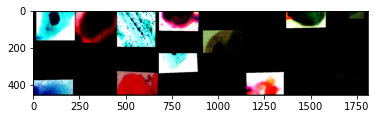

im_Koilocytotic im_Dyskeratotic im_Metaplastic im_Koilocytotic im_Koilocytotic
===== HYPERPARAMETERS =====
batch_size= 16
epochs= 210
learning_rate= 0.0009662520003992713
Epoch 1, Batch_no 12, 10% 	 train_loss: 1.75 took: 23.13s
Epoch 1, Batch_no 25, 20% 	 train_loss: 1.54 took: 20.50s
Epoch 1, Batch_no 38, 30% 	 train_loss: 1.38 took: 17.73s
Epoch 1, Batch_no 51, 41% 	 train_loss: 1.52 took: 19.33s
Epoch 1, Batch_no 64, 51% 	 train_loss: 1.48 took: 19.71s
Epoch 1, Batch_no 77, 61% 	 train_loss: 1.41 took: 24.65s
Epoch 1, Batch_no 90, 72% 	 train_loss: 1.30 took: 19.25s
Epoch 1, Batch_no 103, 82% 	 train_loss: 1.32 took: 15.52s
Epoch 1, Batch_no 116, 92% 	 train_loss: 1.24 took: 21.69s
Training accuracy: 43 %
Validation accuracy: 60 %
Validation loss = 1.02
Epoch 2, Batch_no 12, 10% 	 train_loss: 1.24 took: 3.09s
Epoch 2, Batch_no 25, 20% 	 train_loss: 1.35 took: 2.27s
Epoch 2, Batch_no 38, 30% 	 train_loss: 1.24 took: 2.31s
Epoch 2, Batch_no 51, 41% 	 train_loss: 1.31 took: 2.66s
Epoc

In [0]:
network_simple = simple_testnet(num_classes=5)
#network_simple = ResNet18()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
network_simple.to(device)
train_list,test_list = trainNet(network_simple, batch_size=16, n_epochs=210, learning_rate=0.0009662520003992714)

In [0]:
# load model to memory
restore_point = torch.load('./drive/My Drive/Papsmear_dataset/cpu_simple_testnet_normalized.pth')
fresh_net = simple_testnet(num_classes=5)
fresh_net.load_state_dict(restore_point)
fresh_net.eval()

example = torch.rand(1, 3, 224, 224)
traced_script_module = torch.jit.trace(fresh_net, example)
traced_script_module.save('./drive/My Drive/Papsmear_dataset/cpu_simple_testnet_normalized_loaded.pt')

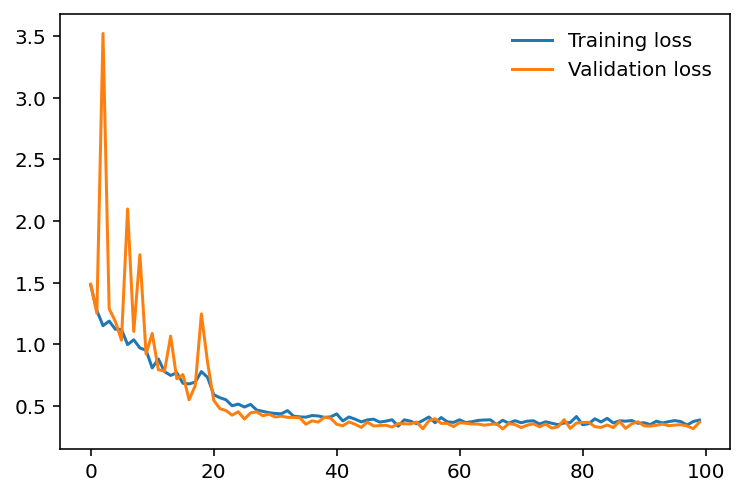

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
plt.plot(train_list, label='Training loss')
plt.plot(test_list, label='Validation loss')
plt.legend(frameon=False)

# Summary

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
network.to(device)
summary(network, batch_size=1, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 16, 112, 112]             432
       BatchNorm2d-2          [1, 16, 112, 112]              32
             ReLU6-3          [1, 16, 112, 112]               0
         h_sigmoid-4          [1, 16, 112, 112]               0
           h_swish-5          [1, 16, 112, 112]               0
            Conv2d-6          [1, 16, 112, 112]             144
       BatchNorm2d-7          [1, 16, 112, 112]              32
              ReLU-8          [1, 16, 112, 112]               0
          Identity-9          [1, 16, 112, 112]               0
           Conv2d-10          [1, 16, 112, 112]             256
      BatchNorm2d-11          [1, 16, 112, 112]              32
 InvertedResidual-12          [1, 16, 112, 112]               0
           Conv2d-13          [1, 64, 112, 112]           1,024
      BatchNorm2d-14          [1, 64, 1